# Visualise Test Results

This notebook merely *visualises* the results that are run by each of the individual scripts in this directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc.mcmc import analyse

%load_ext autoreload
%autoreload 2

/home/steven/miniconda3/envs/py21cmmc_fg/lib/python3.7/site-packages/powerbox/dft.py:51: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


In [2]:
import py21cmmc
py21cmmc.__version__

'0.1.0'

## Gridded Baselines, No Noise, No Foregrounds

### Conceptual Checks

In this section, we check a few plots of various quantities to make sure we understand "what's really going on".

Show the baseline positions (remember we are putting them at a regular grid)

Text(0, 0.5, 'y (m)')

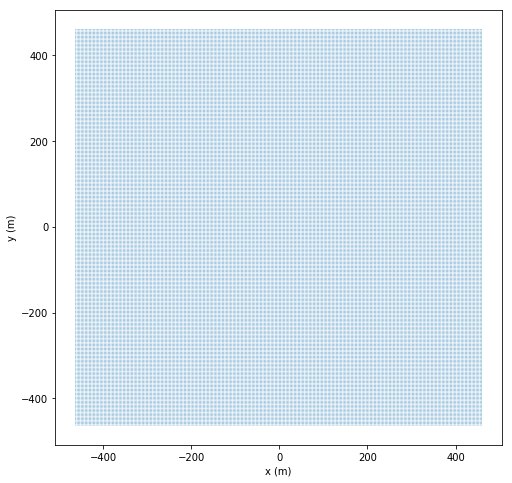

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(likelihood.baselines[:,0], likelihood.baselines[:,1], s=2, marker='.', edgecolor='none')
plt.xlabel("x (m)")
plt.ylabel("y (m)")

Show the underlying simulation brightness temp:

Existing z=8.599200000000002 perturb_field boxes found and read in.
Existing z=8.23 perturb_field boxes found and read in.
Existing z=7.875 perturb_field boxes found and read in.
Sampling the data onto baselines


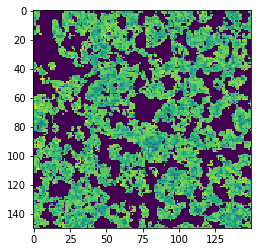

In [8]:
plt.imshow(core_instr.default_ctx.get("lightcone").brightness_temp[:,:, 0])

In [9]:
core_instr.sim_frequencies

array([1.60000000e+08, 1.59754659e+08, 1.59509506e+08, 1.59264544e+08,
       1.59019771e+08, 1.58775188e+08, 1.58530794e+08, 1.58286590e+08,
       1.58042576e+08, 1.57798752e+08, 1.57555115e+08, 1.57311671e+08,
       1.57068414e+08, 1.56825346e+08, 1.56582469e+08, 1.56339781e+08,
       1.56097282e+08, 1.55854974e+08, 1.55612853e+08, 1.55370923e+08,
       1.55129182e+08, 1.54887631e+08, 1.54646268e+08, 1.54405095e+08,
       1.54164114e+08, 1.53923319e+08, 1.53682715e+08, 1.53442299e+08,
       1.53202072e+08, 1.52962035e+08, 1.52722188e+08, 1.52482530e+08,
       1.52243062e+08, 1.52003783e+08, 1.51764692e+08, 1.51525792e+08,
       1.51287079e+08, 1.51048557e+08, 1.50810224e+08, 1.50572080e+08,
       1.50334124e+08, 1.50096360e+08, 1.49858782e+08, 1.49621396e+08,
       1.49384197e+08, 1.49147190e+08])

The sky size (in lm co-ordinates) after tiling/coarsening:

In [10]:
core_instr.sky_size

<Quantity 0.62956416>

The simulated sky after stitching and coarsening (note this code is just copied from the call function, and may change between versions):

Existing z=8.599200000000002 perturb_field boxes found and read in.
Existing z=8.23 perturb_field boxes found and read in.
Existing z=7.875 perturb_field boxes found and read in.
Sampling the data onto baselines


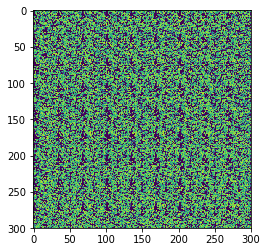

In [11]:
lightcone = core_instr.default_ctx.get("lightcone") #Doing this actually does all of the below, 
                                                    # but the below is not saved to the context...

boxsize = core_instr._base_module.user_params.BOX_LEN
cosmo = core_instr._base_module.cosmo_params.cosmo
EoR_size = ForegroundsBase.get_sky_size(boxsize, core_instr.redshifts, cosmo)

# TODO: stitch stuff together and then coarsen the grid
new_sky = core_instr.stitch_boxes(lightcone.brightness_temp, EoR_size)
if core_instr.n_cells > 0:
    new_sky = core_instr.coarsen_sky(new_sky, n2=core_instr.n_cells)[0]


We can try to look at a single (coarsened) simulation:

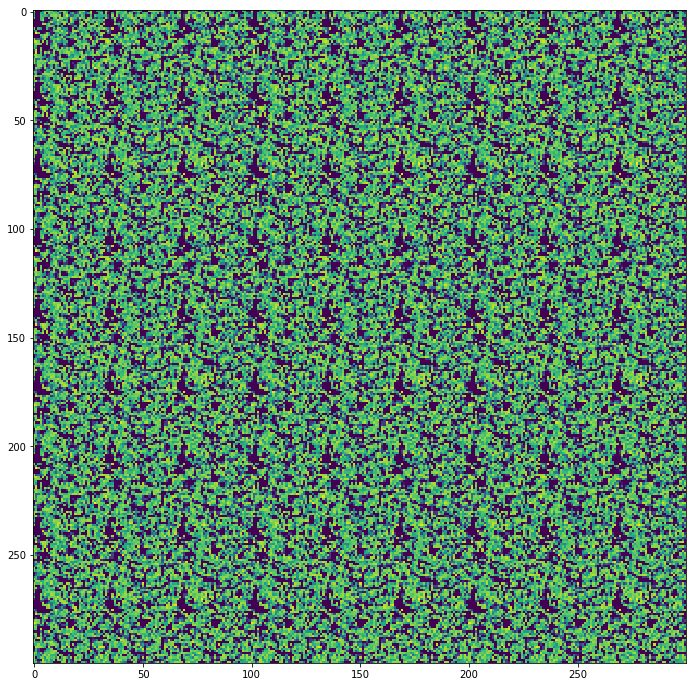

In [12]:
plt.figure(figsize=(12,12))
plt.imshow(new_sky[:,:,0])

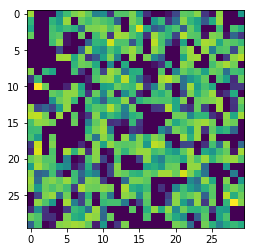

In [14]:
plt.imshow(new_sky[:30,:30,0])

And a gridded power spectrum

In [15]:
power = likelihood.p_data

In [31]:
power

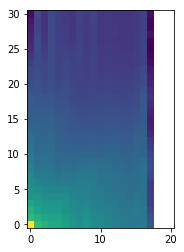

In [16]:
plt.imshow(np.log10(likelihood.p_data.T), origin='lower')

### Analysis

Access the samples object within the chain (see the intro for more details):

In [9]:
samples = analyse.get_samples("data/InstrumentalGridTest")

#### Trace Plot

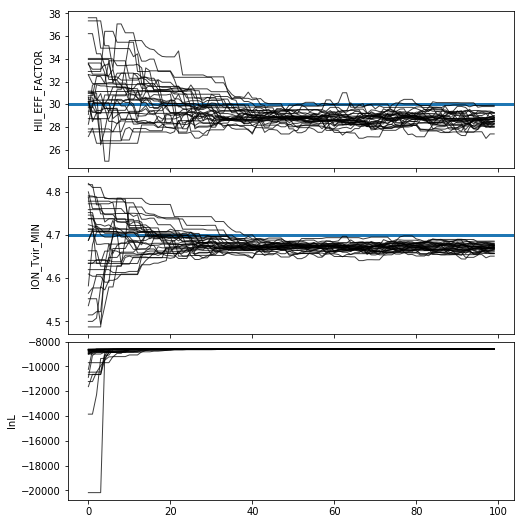

In [10]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

#### Corner Plot

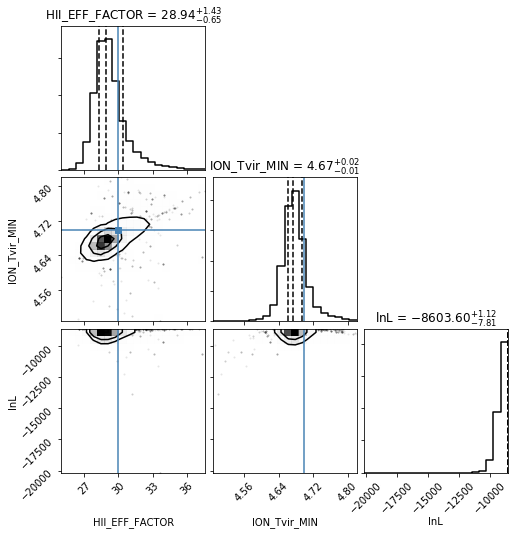

In [12]:
analyse.corner_plot(samples);

## Gridded, Noise, No Foregrounds

In [6]:
modelname = "InstrumentalGridTestNoise"
name = "data/"+modelname

In [7]:
samples = analyse.get_samples(name)
data = np.load(name+'.npz')
noise = np.load(name+".noise.npz")

In [14]:
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True);

AttributeError: No iterations performed for this run.

## Gridded, Noise, PS Foregrounds

In [ ]:
samples = analyse.get_samples("data/In")